In [14]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [15]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
for i in range(0, 10):
    inputImageDir = './input/' + str(i) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [16]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, num_classes):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        res = self.linear(x)
        res = self.activate(res)
        return res

In [17]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [18]:
# Parameters of training
input_size = 256
num_classes = 256
learning_rate = 0.001
batch_size = 10
num_epochs = 600

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, num_classes=num_classes).to(device)

if not os.path.exists('./models'):
    os.mkdir('./models')
torch.save(model, './models/net_untrained.pkl')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [109]:
# Step 3
model = Perceptron(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = [] 
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
#             print('inputv: %s' % inputv)
#             print('err: %s' % err)
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2515 MAE: 0.4858 Mean Error: 0.4067 STD: 0.2934
[10/600] Loss: 0.0429 MAE: 0.1530 Mean Error: 0.0928 STD: 0.1852
[20/600] Loss: 0.0306 MAE: 0.0905 Mean Error: 0.0314 STD: 0.1720
[30/600] Loss: 0.0281 MAE: 0.0777 Mean Error: 0.0198 STD: 0.1665
[40/600] Loss: 0.0264 MAE: 0.0731 Mean Error: 0.0161 STD: 0.1617
[50/600] Loss: 0.0249 MAE: 0.0705 Mean Error: 0.0143 STD: 0.1572
[60/600] Loss: 0.0235 MAE: 0.0685 Mean Error: 0.0129 STD: 0.1529
[70/600] Loss: 0.0222 MAE: 0.0671 Mean Error: 0.0129 STD: 0.1485
[80/600] Loss: 0.0210 MAE: 0.0656 Mean Error: 0.0123 STD: 0.1444
[90/600] Loss: 0.0199 MAE: 0.0640 Mean Error: 0.0120 STD: 0.1405
[100/600] Loss: 0.0188 MAE: 0.0623 Mean Error: 0.0117 STD: 0.1366
[110/600] Loss: 0.0178 MAE: 0.0606 Mean Error: 0.0115 STD: 0.1329
[120/600] Loss: 0.0168 MAE: 0.0591 Mean Error: 0.0112 STD: 0.1293
[130/600] Loss: 0.0159 MAE: 0.0575 Mean Error: 0.0110 STD: 0.1258
[140/600] Loss: 0.0151 MAE: 0.0560 Mean Error: 0.0107 STD: 0.1224
[150/600] Loss: 0.014

In [162]:
# Step 4
# Step 4a
# Export the image after training
# Before executing this block, create a folder called "output"
if not os.path.exists('./output'):
    os.mkdir('./output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models/net_trained.pkl')
output_dataset = np.zeros([10, 256])
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
#     img = img.convert("1")
    threshold = 50
    img = img.point(lambda p: p > threshold and 255)
    output_path = './output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(10, 256)


In [30]:
# Step 4b
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [31]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [167]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.92       0.91891892 0.95       0.93975904 0.95238095 0.95348837
 0.94155844 0.94674556 0.94387755 0.94570136]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
# TODO: Step 4c: Graph Fh as a function of Ffa for each exemplar in the input dataset

In [163]:
# Step 5
def gaussian_noise(img, mean, sigma):
    # Generate gauss noise
    noise = np.random.normal(mean, sigma, img.shape)
    # Add the noise to image
#     print(noise)
    gaussian_out = img + noise
#     print(img)
    # Make the value between 0 and 1
    gaussian_out = np.clip(gaussian_out, 0, 1)
    return gaussian_out

gaussian_dataset = np.zeros([9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
if not os.path.exists('./input_noise/'):
    os.mkdir('./input_noise/')
for j in range(9):
    if not os.path.exists('./input_noise/' + str(std[j])):
        os.mkdir('./input_noise/' + str(std[j]))
    for i in range(10):
        inputImage = dataSet[i]
        gaussian_data = gaussian_noise(inputImage, 0, std[j])
        img = gaussian_data.reshape(16, 16)*255
        img = Image.fromarray(np.uint8(img))
        img.convert("1")
#         threshold = 38
#         img = img.point(lambda p: p > threshold and 255)
        inputImageDir = './input_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(inputImageDir)
        gaussian_dataset[j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)


Fh_noise_array = np.zeros([9, 10])
Ffa_noise_array = np.zeros([9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise/'):
    os.mkdir('./output_noise/')
for j in range(9):
    train_noise_dataset = DigitDataset(dataset = gaussian_dataset[j], label_list = dataSet)
    train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
    print('Training dataset with noise standard deviation ' + str(std[j]))
#     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
    model_noise = Perceptron(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)
    output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
    torch.save(model_noise, './models/net_trained_' + str(std[j]) + '.pkl')
    model_noise = torch.load('./models/net_trained_' + str(std[j]) + '.pkl')
#     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
    print('------------------------------------')
    output_noise = model_noise(torch.from_numpy(dataSet).float())
    output_noise_np = output_noise.detach().numpy()     # Get the output
#     print(output_noise_np)
    output_noise_dataset = np.zeros([10, 256])
#     Make the output only has 0 or 1
    
    if not os.path.exists('./output_noise/' + str(std[j])):
        os.mkdir('./output_noise/' + str(std[j]))
    for i in range(10):
        output_noise_img = output_noise_np[i].reshape(16, 16)*255
        img = Image.fromarray(np.uint8(output_noise_img))
#         img = img.convert("1")
        threshold = 50
        img = img.point(lambda p: p > threshold and 255)
        output_path = './output_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(output_path)
        data = img.getdata()
        array = np.array(data)/255
        output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    Fh = calculateFh(dataSet, output_noise_dataset)
    Ffa = calculateFfa(dataSet, output_noise_dataset)
    Fh_noise_array[j] = Fh
    Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[ 4.64586480e-04 -4.57996055e-04  1.67249920e-03 -1.56264111e-03
  6.90114075e-04 -1.86814173e-03  1.82249935e-03 -4.23806387e-04
  4.04186382e-04  2.16747857e-03  1.97578971e-03 -7.23122044e-04
 -1.17425614e-03 -1.32640545e-03 -1.16621142e-03  1.23737567e-03
  5.47424885e-04 -1.54844133e-04  2.26866401e-03  1.66579130e-03
 -3.09722099e-04  8.60300124e-04 -7.89643485e-04 -3.32910275e-04
  8.94930194e-04  7.42258625e-05  1.01164798e-03  3.64895622e-04
 -5.91993298e-04  3.59360997e-05 -3.27864556e-04  1.14662675e-03
 -9.32475362e-04 -2.60333994e-03  3.14280560e-04  5.26537658e-04
  7.57341933e-04 -5.98776952e-05 -4.20451401e-04 -1.80363612e-04
  8.82580296e-04  3.23685268e-03  6.45117706e-04 -3.68309176e-04
  5.78480983e-04  5.52464837e-04 -9.85348568e-05  4.57665763e-04
 -8.54961430e-04 -5.42453875e-04 -1.15261727e-03 -1.57605394e-03
 -2.25174023e-04 -1.00763060e-03  6.77756631e-04  7.65431171e-04
  1.71274822e-03 -1.54672509e-04 -3.01012450e-04 -3.09327033e-05
 -2.74304435e-04 -5.64064

[ 1.42363818e-03 -2.34731171e-03 -9.85499579e-03 -9.73107573e-03
  1.01761496e-03  9.29197425e-03  2.38476938e-03 -5.72621482e-03
 -6.76517135e-03 -1.69700665e-03 -2.38485570e-03  1.66283610e-03
 -1.62483910e-02 -8.02622579e-03 -9.83793994e-03 -1.29621731e-02
 -3.12451448e-03  8.22369395e-03  3.39686169e-03  9.36909130e-03
  1.19082679e-02 -1.21651808e-03 -1.83834670e-02  1.51170456e-02
 -1.07710083e-02  1.26811306e-02  6.64131803e-03 -9.85429523e-03
 -2.48534445e-03 -2.28031859e-02 -1.50872724e-03  6.75244796e-04
  2.03204485e-02 -9.36866091e-03 -1.30118415e-02 -9.26833153e-03
  3.43350169e-02  1.01868455e-02 -1.33539980e-02  2.24932845e-03
 -9.01355001e-03  6.06178233e-03  1.57139834e-02  8.62948363e-03
  1.75862198e-02  1.36052717e-02  3.39051485e-03 -7.49494935e-03
  3.19709289e-03 -3.79084236e-03  7.63242035e-03  1.53570649e-02
  8.39376856e-03  9.64826022e-03  6.93741276e-03 -7.42105466e-04
 -7.15117467e-04 -7.14247123e-03  5.88144911e-03  2.72684703e-03
 -1.16955361e-02 -4.89417

[ 0.21990182  0.12463518  0.04296061  0.0970935   0.02987116  0.016032
  0.02697776  0.03287548 -0.00415369  0.00371894  0.14482454 -0.12620739
  0.00945364 -0.2256906  -0.18258662  0.03274494  0.04041154  0.00239242
 -0.04636529 -0.01225563  0.1030876   0.12390856 -0.02953946 -0.05076512
  0.04689243  0.08639127 -0.00838884 -0.02463369 -0.05782436 -0.11829778
  0.00970723  0.0863432   0.24226225  0.17096597 -0.07756273  0.04284739
  0.11570124 -0.08249524 -0.06138874 -0.24460744 -0.00448723  0.05126502
 -0.04568129 -0.07487768 -0.00274108  0.02933248 -0.18825436  0.05864943
  0.23556979  0.0606599   0.0372444   0.14346506  0.15084817 -0.06297885
  0.01425923 -0.17369093 -0.16611321 -0.15918297 -0.03088012  0.10960625
 -0.04246352  0.03943276 -0.06377151  0.061594    0.01671825 -0.00645586
 -0.17111955  0.11044693 -0.09128084 -0.12581875 -0.16925379  0.06912919
 -0.11453392 -0.11177158  0.08496286  0.04420679  0.18054023 -0.03740482
 -0.00287651 -0.00144953  0.08039145 -0.07306886  0.0

[70/600] Loss: 0.0221 MAE: 0.0672 Mean Error: 0.0131 STD: 0.1481
[80/600] Loss: 0.0209 MAE: 0.0655 Mean Error: 0.0127 STD: 0.1439
[90/600] Loss: 0.0197 MAE: 0.0639 Mean Error: 0.0123 STD: 0.1400
[100/600] Loss: 0.0187 MAE: 0.0623 Mean Error: 0.0120 STD: 0.1361
[110/600] Loss: 0.0177 MAE: 0.0607 Mean Error: 0.0117 STD: 0.1324
[120/600] Loss: 0.0167 MAE: 0.0591 Mean Error: 0.0115 STD: 0.1288
[130/600] Loss: 0.0158 MAE: 0.0575 Mean Error: 0.0112 STD: 0.1253
[140/600] Loss: 0.0150 MAE: 0.0560 Mean Error: 0.0109 STD: 0.1219
[150/600] Loss: 0.0142 MAE: 0.0546 Mean Error: 0.0107 STD: 0.1186
[160/600] Loss: 0.0134 MAE: 0.0532 Mean Error: 0.0105 STD: 0.1155
[170/600] Loss: 0.0127 MAE: 0.0518 Mean Error: 0.0103 STD: 0.1125
[180/600] Loss: 0.0121 MAE: 0.0505 Mean Error: 0.0100 STD: 0.1095
[190/600] Loss: 0.0115 MAE: 0.0492 Mean Error: 0.0098 STD: 0.1067
[200/600] Loss: 0.0109 MAE: 0.0480 Mean Error: 0.0096 STD: 0.1040
[210/600] Loss: 0.0104 MAE: 0.0468 Mean Error: 0.0094 STD: 0.1014
[220/600] Los

[130/600] Loss: 0.0157 MAE: 0.0575 Mean Error: 0.0111 STD: 0.1248
[140/600] Loss: 0.0148 MAE: 0.0559 Mean Error: 0.0108 STD: 0.1214
[150/600] Loss: 0.0140 MAE: 0.0544 Mean Error: 0.0106 STD: 0.1181
[160/600] Loss: 0.0133 MAE: 0.0530 Mean Error: 0.0103 STD: 0.1149
[170/600] Loss: 0.0126 MAE: 0.0516 Mean Error: 0.0101 STD: 0.1118
[180/600] Loss: 0.0120 MAE: 0.0503 Mean Error: 0.0099 STD: 0.1089
[190/600] Loss: 0.0113 MAE: 0.0490 Mean Error: 0.0096 STD: 0.1061
[200/600] Loss: 0.0108 MAE: 0.0477 Mean Error: 0.0094 STD: 0.1034
[210/600] Loss: 0.0102 MAE: 0.0465 Mean Error: 0.0092 STD: 0.1008
[220/600] Loss: 0.0098 MAE: 0.0454 Mean Error: 0.0090 STD: 0.0984
[230/600] Loss: 0.0093 MAE: 0.0443 Mean Error: 0.0089 STD: 0.0960
[240/600] Loss: 0.0089 MAE: 0.0432 Mean Error: 0.0087 STD: 0.0937
[250/600] Loss: 0.0084 MAE: 0.0422 Mean Error: 0.0085 STD: 0.0915
[260/600] Loss: 0.0081 MAE: 0.0412 Mean Error: 0.0083 STD: 0.0894
[270/600] Loss: 0.0077 MAE: 0.0403 Mean Error: 0.0082 STD: 0.0874
[280/600] 

[170/600] Loss: 0.0129 MAE: 0.0518 Mean Error: 0.0099 STD: 0.1133
[180/600] Loss: 0.0123 MAE: 0.0505 Mean Error: 0.0097 STD: 0.1104
[190/600] Loss: 0.0117 MAE: 0.0492 Mean Error: 0.0095 STD: 0.1077
[200/600] Loss: 0.0111 MAE: 0.0480 Mean Error: 0.0093 STD: 0.1050
[210/600] Loss: 0.0106 MAE: 0.0468 Mean Error: 0.0091 STD: 0.1024
[220/600] Loss: 0.0101 MAE: 0.0457 Mean Error: 0.0089 STD: 0.1000
[230/600] Loss: 0.0096 MAE: 0.0446 Mean Error: 0.0087 STD: 0.0976
[240/600] Loss: 0.0092 MAE: 0.0436 Mean Error: 0.0086 STD: 0.0953
[250/600] Loss: 0.0087 MAE: 0.0426 Mean Error: 0.0084 STD: 0.0931
[260/600] Loss: 0.0083 MAE: 0.0416 Mean Error: 0.0082 STD: 0.0910
[270/600] Loss: 0.0080 MAE: 0.0407 Mean Error: 0.0081 STD: 0.0890
[280/600] Loss: 0.0076 MAE: 0.0398 Mean Error: 0.0079 STD: 0.0870
[290/600] Loss: 0.0073 MAE: 0.0390 Mean Error: 0.0078 STD: 0.0851
[300/600] Loss: 0.0070 MAE: 0.0381 Mean Error: 0.0076 STD: 0.0833
[310/600] Loss: 0.0067 MAE: 0.0373 Mean Error: 0.0075 STD: 0.0816
[320/600] 

[190/600] Loss: 0.0113 MAE: 0.0491 Mean Error: 0.0098 STD: 0.1060
[200/600] Loss: 0.0108 MAE: 0.0479 Mean Error: 0.0096 STD: 0.1033
[210/600] Loss: 0.0102 MAE: 0.0467 Mean Error: 0.0094 STD: 0.1007
[220/600] Loss: 0.0097 MAE: 0.0455 Mean Error: 0.0092 STD: 0.0983
[230/600] Loss: 0.0093 MAE: 0.0444 Mean Error: 0.0090 STD: 0.0959
[240/600] Loss: 0.0088 MAE: 0.0433 Mean Error: 0.0088 STD: 0.0936
[250/600] Loss: 0.0084 MAE: 0.0423 Mean Error: 0.0086 STD: 0.0914
[260/600] Loss: 0.0080 MAE: 0.0414 Mean Error: 0.0084 STD: 0.0893
[270/600] Loss: 0.0077 MAE: 0.0404 Mean Error: 0.0082 STD: 0.0873
[280/600] Loss: 0.0074 MAE: 0.0395 Mean Error: 0.0081 STD: 0.0854
[290/600] Loss: 0.0070 MAE: 0.0387 Mean Error: 0.0079 STD: 0.0835
[300/600] Loss: 0.0067 MAE: 0.0378 Mean Error: 0.0078 STD: 0.0817
[310/600] Loss: 0.0065 MAE: 0.0370 Mean Error: 0.0076 STD: 0.0800
[320/600] Loss: 0.0062 MAE: 0.0363 Mean Error: 0.0075 STD: 0.0784
[330/600] Loss: 0.0059 MAE: 0.0355 Mean Error: 0.0074 STD: 0.0768
[340/600] 

[230/600] Loss: 0.0087 MAE: 0.0437 Mean Error: 0.0094 STD: 0.0926
[240/600] Loss: 0.0082 MAE: 0.0426 Mean Error: 0.0092 STD: 0.0902
[250/600] Loss: 0.0078 MAE: 0.0415 Mean Error: 0.0091 STD: 0.0879
[260/600] Loss: 0.0074 MAE: 0.0405 Mean Error: 0.0089 STD: 0.0856
[270/600] Loss: 0.0070 MAE: 0.0395 Mean Error: 0.0087 STD: 0.0835
[280/600] Loss: 0.0067 MAE: 0.0386 Mean Error: 0.0085 STD: 0.0814
[290/600] Loss: 0.0064 MAE: 0.0377 Mean Error: 0.0084 STD: 0.0795
[300/600] Loss: 0.0061 MAE: 0.0368 Mean Error: 0.0082 STD: 0.0776
[310/600] Loss: 0.0058 MAE: 0.0360 Mean Error: 0.0081 STD: 0.0758
[320/600] Loss: 0.0055 MAE: 0.0352 Mean Error: 0.0079 STD: 0.0741
[330/600] Loss: 0.0053 MAE: 0.0344 Mean Error: 0.0078 STD: 0.0724
[340/600] Loss: 0.0051 MAE: 0.0337 Mean Error: 0.0077 STD: 0.0708
[350/600] Loss: 0.0049 MAE: 0.0330 Mean Error: 0.0075 STD: 0.0693
[360/600] Loss: 0.0046 MAE: 0.0323 Mean Error: 0.0074 STD: 0.0678
[370/600] Loss: 0.0045 MAE: 0.0317 Mean Error: 0.0073 STD: 0.0664
[380/600] 

In [13]:
# TODO: Step 6: Display Data from your Tests in Step 5

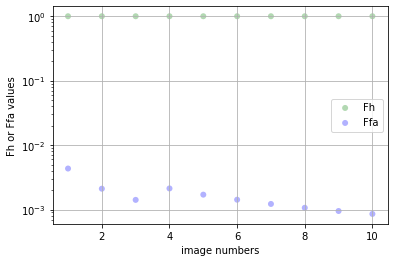

In [56]:
import numpy as np
import matplotlib.pyplot as plt

std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
plt.yscale("log")
plt.show()


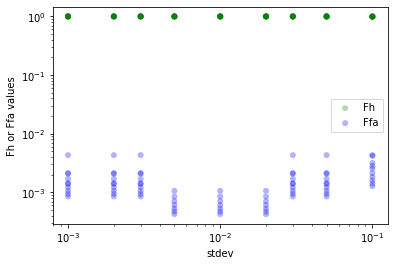

In [54]:
# noise
fig, ax = plt.subplots()
ax.scatter(std_plot, Fh_noise_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(std_plot, Ffa_noise_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
plt.xscale("log")
plt.yscale("log")
ax.legend()
plt.show()

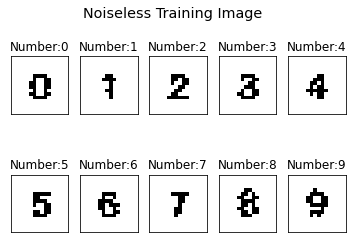

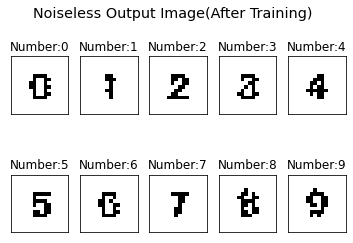

In [164]:
N=2
M=5
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Noiseless Training Image", fontsize="x-large")
for i in range(10):#有10张图片
    path='./input/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

N=2
M=5
fig = plt.figure()
st = fig.suptitle("Noiseless Output Image(After Training)", fontsize="x-large")
for i in range(10):#有10张图片
    path='./output/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

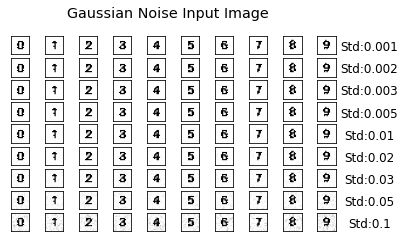

In [165]:
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=500
M=500
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./input_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = ("Std:"+str(j))
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

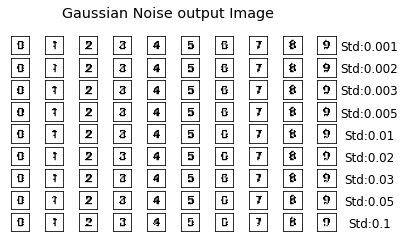

In [1]:
# Display the Onput Image with Noise 
import matplotlib.pyplot as plt
import numpy as np
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=100
M=100
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise output Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./output_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = "Std:"+str(j)
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

In [ ]:
import sys
train_noise_dataset = DigitDataset(dataset = gaussian_dataset[-1], label_list = dataSet)
train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
print('Training dataset with noise standard deviation ' + str(std[-1]))
model_noise = Perceptron(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)
# np.set_printoptions(threshold=sys.maxsize)
output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
torch.save(model_noise, './models/net_trained_' + str(std[-1]) + '.pkl')
model_noise = torch.load('./models/net_trained_' + str(std[-1]) + '.pkl')
#     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
print('------------------------------------')
output_noise = model_noise(torch.from_numpy(dataSet).float())
output_noise_np = output_noise.detach().numpy()     # Get the output
#     print(output_noise_np)
output_noise_dataset = np.zeros([10, 256])
#     Make the output only has 0 or 1

if not os.path.exists('./output_noise/' + str(std[-1])):
    os.mkdir('./output_noise/' + str(std[-1]))
for i in range(10):
    output_noise_img = output_noise_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_noise_img))
#     img = img.convert("1")
    threshold = 38
    img = img.point(lambda p: p > threshold and 255)
    output_path = './output_noise/' + str(std[-1]) + '/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_noise_dataset[i] = array
#     Calculate Fh and Ffa
Fh = calculateFh(dataSet, output_noise_dataset)
Ffa = calculateFfa(dataSet, output_noise_dataset)
Fh_noise_array[-1] = Fh
Ffa_noise_array[-1] = Ffa
print(str(std[-1]))

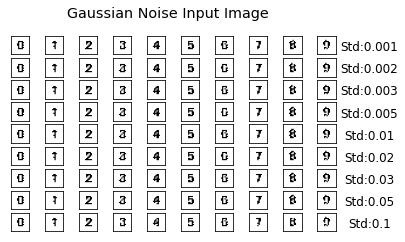

In [7]:
# Display the Onput Image with Noise 
import matplotlib.pyplot as plt
import numpy as np
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=100
M=100
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./data/data/SLP_output_noise_image/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = "Std:"+str(j)
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()